In [1]:
from dendrocat import RadioSource
from astropy.io import fits
from spectral_cube import SpectralCube
import matplotlib.pyplot as plt
from matplotlib.colors import LogNorm
import numpy as np
import sys
import importlib
from astropy.wcs import WCS
from scipy import interpolate
import pandas as pd
import sympy as syp
from astropy import units as u
import radio_beam
from astropy.table import Table
from radio_beam import Beam
from astropy import coordinates
from astropy import wcs
from astropy.nddata.utils import Cutout2D
from dendrocat.aperture import Ellipse
from regions import Regions, PixCoord
from astropy import stats
from itertools import chain
from radio_beam import Beams
from astropy.convolution import convolve
import seaborn as sns
import Paths.Paths as paths
Path = paths.filepaths()

def cen_freq(center, delta ,alpha=2):
    start = center-delta/2 ; end = center+delta/2
    freqarr = np.logspace(np.log10(start),np.log10(end),20)
    dfreq = freqarr[1:]-freqarr[:-1]
    dfreq = np.append(dfreq,[dfreq[-1]])
    
    integral_up = np.sum(freqarr**(alpha+1)*dfreq)
    integral_down = np.sum(freqarr**(alpha)*dfreq)
    return integral_up/integral_down

def get_noise(image, wcsNB, noiseregion):
    container = []
    for reg in noiseregion:
        pix_reg = reg.to_pixel(wcsNB)
        noisemask = pix_reg.to_mask()
        noiseim = noisemask.cutout(image)
        container.append(noiseim.flatten())
    noiseim = list(chain.from_iterable(container))
    std = stats.mad_std(noiseim,ignore_nan=True)

    return std




def measure_alpha(b3data, b6data, b3noisereg, b6noisereg, table, b6image=None, b6noise=None, save=True,sigma=3):
    t = Table.read(table)
    peakx_b6 = t['b6_xsky']
    peaky_b6 = t['b6_ysky']
    b6outside = np.where(t['is_overlap']==False)[0]
    peakxy_b6 = np.vstack((peakx_b6,peaky_b6)).T
    
    b6unmatched = np.where(peakx_b6<0)[0]

    peakx_b3 = t['b3_xsky']
    peaky_b3 = t['b3_ysky']
    peakxy_b3 = np.vstack((peakx_b3,peaky_b3)).T
    b3outside = np.where(t['is_overlap']==False)[0]

    b3unmatched = np.where(peakx_b3<0)[0]

    print('unmatched',len(b6unmatched),len(b3unmatched))
    fitsdata_b3 = fits.open(b3data)
    imageb3 = fitsdata_b3[0].data
    if len(imageb3.shape)!=2:
        imageb3 = imageb3[0][0]
    
    fitsdata_b6 = fits.open(b6data)
    imageb6 = fitsdata_b6[0].data
    if len(imageb6.shape)!=2:
        imageb6 = imageb6[0][0]
    if b6image is not None:
        imageb6 = b6image
    hdrNB6 = fits.getheader(b6data)  
    hdrNB3 = fits.getheader(b3data)  
    wcsNB3 = WCS(hdrNB3,naxis=2)
    wcsNB6 = WCS(hdrNB6,naxis=2)
    
    b3noise = get_noise(imageb3, wcsNB3, b3noisereg)
    
    if b6noise is None:
        b6noise = get_noise(imageb6, wcsNB6, b6noisereg)
    print('noise',b3noise,b6noise)
    


    scaleNB3 = wcsNB3.proj_plane_pixel_scales()[0]
    scaleNB6 = wcsNB6.proj_plane_pixel_scales()[0]

    scaleNB3_sr = (scaleNB3 * np.pi/180)**2
    scaleNB6_sr = (scaleNB6 * np.pi/180)**2


    num_source = len(peakxy_b6)
    
    peakxy_b6_pix = wcsNB6.wcs_world2pix(peakxy_b6,0)
    peakxy_b3_pix = wcsNB3.wcs_world2pix(peakxy_b3,0)
    
    B6flux = [imageb6[int(xypix[1]),int(xypix[0])] if xypix[1]<imageb6.shape[0] and xypix[1]>0 else np.nan for xypix in peakxy_b6_pix]
    B3flux = [imageb3[int(xypix[1]),int(xypix[0])] if xypix[1]<imageb3.shape[0] and xypix[1]>0 else np.nan for xypix in peakxy_b3_pix]

    B6flux = np.array(B6flux)
    B3flux = np.array(B3flux)
    print(b6unmatched)
    #B6flux[b6unmatched] = simga*b6noise
    #B3flux[b3unmatched] = sigma*b3noise
    B6flux[b6unmatched] = np.nan
    B3flux[b3unmatched] = np.nan
    
    freqb3 = cen_freq(hdrNB3['CRVAL3'],hdrNB3['CDELT4'])
    freqb6 = cen_freq(hdrNB6['CRVAL4'],hdrNB6['CDELT4'])
    print(freqb3, freqb6)
    alpha = np.log10(B3flux/B6flux)/np.log10(freqb3/freqb6)
    #alphaerr = np.sqrt((b3noise/B3flux)**2+(b6noise/B6flux)**2)/B3flux*B6flux/np.log(freqb3/freqb6)
    alphaerr = np.abs(np.sqrt((b3noise/B3flux)**2+(b6noise/B6flux)**2)/np.log(10)/np.log10(freqb3/freqb6))
    alpha[b3outside] = np.nan
    alpha[b6outside] = np.nan
    print(alpha)
    if save:
        t['flux_peak_b3'] = B3flux
        t['flux_peak_b6'] = B6flux
        t['alpha'] = alpha
        t['alphaerr'] = alphaerr

        t.write(table,format='fits',overwrite=True)

    
    return alpha, alphaerr, B3flux, B6flux, b3noise, b6noise

read_w51e_b3_noise = Regions.read(Path.w51e_b3_noise_region,format='ds9')
read_w51e_b6_noise = Regions.read(Path.w51e_b6_noise_region,format='ds9')
read_w51n_b3_noise = Regions.read(Path.w51n_b3_noise_region,format='ds9')
read_w51n_b6_noise = Regions.read(Path.w51n_b6_noise_region,format='ds9')








/home/t.yoo/anaconda3/lib/python3.9/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.26.4
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


In [2]:
fitsdata_b6 = fits.open(Path.w51e_b6_conv)
imageb6 = fitsdata_b6[0].data
if len(imageb6.shape)!=2:
    imageb6 = imageb6[0][0]
alpha_w51e, alphaerr_w51e, b3flux, b6flux, b3noise, b6noise = measure_alpha(Path.w51e_b3_tt0, Path.w51e_b6_conv,read_w51e_b3_noise,read_w51e_b6_noise,
 Path.w51e_dendro_matched_catalog_new,
                                                                            b6noise =0.00012361802520203196, save=True )



unmatched 26 30
noise 2.0344283073177807e-05 0.00012361802520203196
[ 69  70  71  72  73  74  75  76  77  78  79  80  81  82  83 114 115 116
 117 118 119 120 121 122 123 124]
92982346121.91989 226691598706.70853
[2.90700581 2.37670205 2.26425163 3.17219169 2.81678195 2.4105209
 2.36906346 0.58456388 2.18430183 2.2591925  2.22759915 2.64088517
 1.83262883 2.18403589 2.30922667 2.70839342 2.31353721 2.54698832
 3.22346774 2.674717   1.94738907 2.35012098 1.82631406 2.61079445
 2.95094451 2.51844609 2.52540243 1.83819351 1.07553789 2.49075149
 1.37337041 2.04075962 2.32848225 2.85523443 1.82139754 2.7858432
 1.65518552 1.7709949  2.08482294 2.29665473 1.83330311 2.54865338
 2.58484819 2.01275698 2.0040247  2.58937004 2.35237474 1.9230241
 2.51983301 2.69510138 2.2791231  2.57164323 3.08963194 2.2919536
 3.03464109 2.20294704 2.1759383  2.17183873 2.34071535 2.31956132
 2.46046021 2.30878187 1.22780955 2.64898919 2.06029967 3.28109127
 1.96907623 2.62741486 2.74788848        nan        nan

In [3]:
#b6image = convolveb3b6(w51n_b3_tt0,w51n_b6_calibrated_pbcor,'/orange/adamginsburg/w51/TaehwaYoo/convolved_new/','w51n_new_nocorr_in_area')#

#alpha_w51n,alphaerr_w51n ,b3flux, b6flux, b3noise, b6noise = measure_alpha(w51n_b3_tt0, w51n_b6_conv,read_w51n_b3_noise,read_w51n_b6_noise, w51n_matched_catalog,b6image=b6image)
fitsdata_b6 = fits.open(Path.w51n_b6_conv)
imageb6 = fitsdata_b6[0].data
if len(imageb6.shape)!=2:
    imageb6 = imageb6[0][0]
alpha_w51n, alphaerr_w51n, b3flux, b6flux, b3noise, b6noise = measure_alpha(Path.w51n_b3_tt0, Path.w51n_b6_conv,read_w51n_b3_noise,read_w51n_b6_noise, Path.w51n_dendro_matched_catalog_new,
                                                                            b6noise =8.95845803518789e-05, save=True )



unmatched 59 12
noise 2.046915070510816e-05 8.95845803518789e-05
[23 24 25 26 27 28 29 30 43 44 45 46 47 48 49 50 51 52 53 54 55 56 57 58
 59 60 61 62 63 64 65 66 67 68 69 70 71 72 73 74 75 76 77 78 79 80 81 82
 83 84 85 86 87 88 89 90 91 92 93]
92982344741.79 226691594459.07156
[2.93252008 1.87782896 0.71018477 2.25302732 0.21386633 2.16950112
 2.34245758 2.68291807 2.27843892 2.30570463 1.82121133 1.82258199
 2.74378762 1.76811704 2.16826776 1.46373527 2.76495327 2.91979576
 1.35703576 1.75213702 1.8887475  2.10796703 2.0953446         nan
        nan        nan        nan        nan        nan        nan
        nan        nan        nan        nan        nan        nan
        nan        nan        nan        nan        nan        nan
        nan        nan        nan        nan        nan        nan
        nan        nan        nan        nan        nan        nan
        nan        nan        nan        nan        nan        nan
        nan        nan        nan        nan      

ho
     flux_peak_b3     
----------------------
0.00028981672949157655
 0.0003622146905399859
  0.000723325414583087
 0.0002649113885127008
 0.0010115148033946753
 0.0002912691852543503
0.00024948277859948575
 0.0011108798207715154
 0.0018308806465938687
 0.0011863460531458259
 0.0012209415435791016
 0.0005888029700145125
 0.0006863924791105092
  0.000640205922536552
0.00020551640773192048
0.00022997977794148028
0.00048157619312405586
0.00022161494416650385
0.00022471438569482416
 0.0005825479165650904
 0.0029631643556058407
 0.0007817334262654185
 0.0012890561483800411
0.00014545537123922259
 0.0005030257743783295
 0.0016793574905022979
 8.683576743351296e-05
  0.002507863100618124
  0.003998085390776396
 0.0015531436074525118
  0.010856641456484795
 0.0010323168244212866
0.00019100721692666411
0.00018334992637392133
 0.0011655690614134073
0.00034410154330544174
   0.01166063267737627
  0.004640255589038134
0.00015749425801914185
 0.0011846469715237617
 0.0007429184042848647
  0.0002

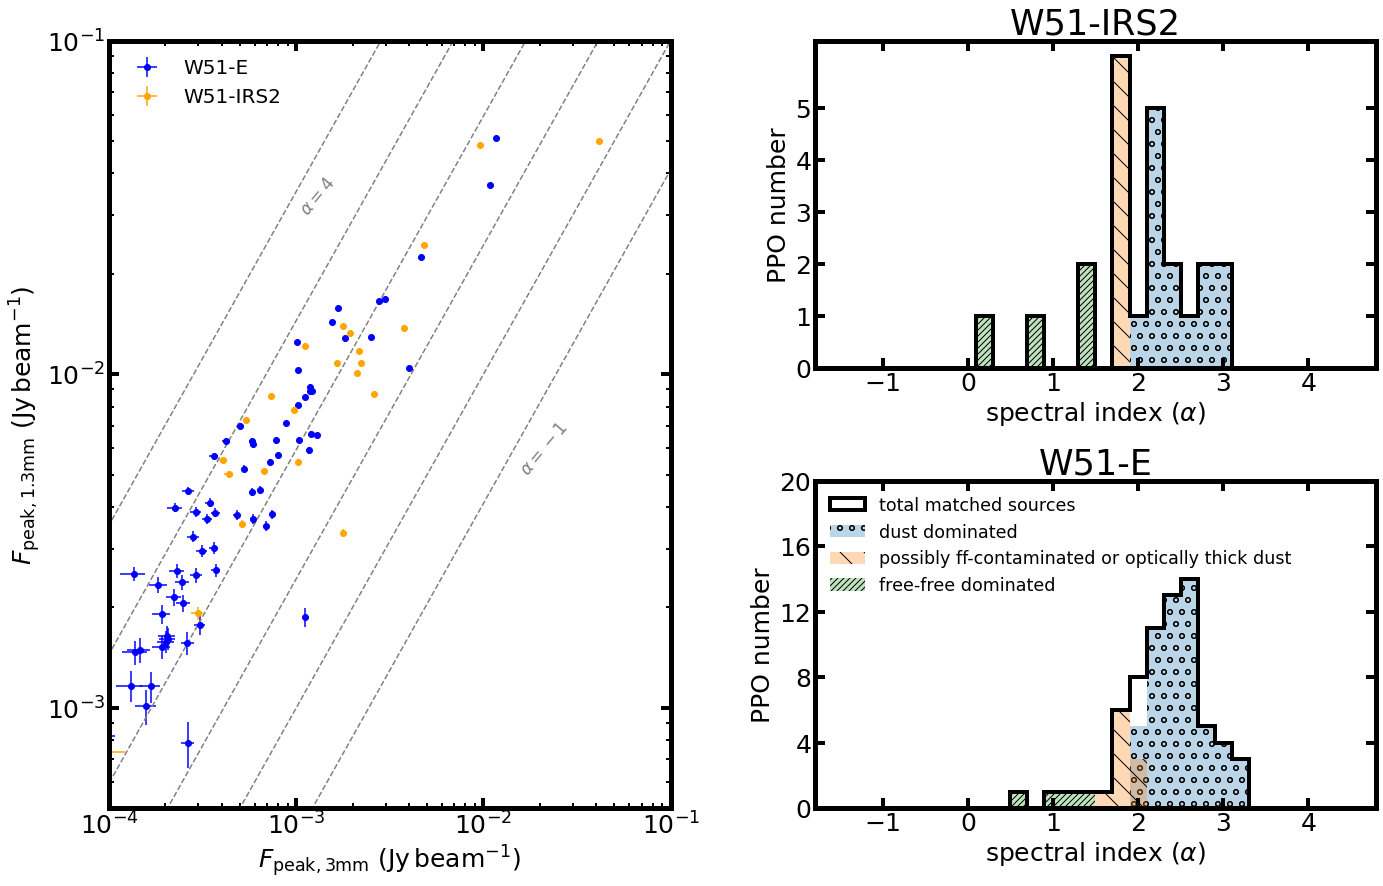

In [4]:
import matplotlib as mpl
import astropy.constants as c
from scipy.interpolate import CubicSpline

def get_bb_intensity(freq, surf_den,T_thin):
    
    kappa_ = kappa(freq)
    
    I_nu =  2 * c.h * freq**3 / (c.c**2) * (np.e**(c.h*freq/(c.k_B*T_thin)) - 1)**(-1) * (1 - np.e**((-kappa_ * surf_den).to(u.dimensionless_unscaled))) /u.sr
    
    return I_nu.to(u.Jy/u.sr)
def kappa(nu, nu0=271.1*u.GHz, kappa0=0.0114*u.cm**2*u.g**-1, beta=1.75):
    """
    Compute the opacity $\kappa$ given a reference frequency (or wavelength)
    and a power law governing the opacity as a fuction of frequency:
    $$ \kappa = \kappa_0 \left(\\frac{\\nu}{\\nu_0}\\right)^{\\beta} $$
    The default kappa=0.0114 at 271.1 GHz comes from extrapolating the
    Ossenkopf & Henning 1994 opacities for the thin-ice-mantle, 10^6 year model
    anchored at 1.0 mm with an assumed beta of 1.75.
    Parameters
    ----------
    nu: astropy.Quantity [u.spectral() equivalent]
        The frequency at which to evaluate kappa
    nu0: astropy.Quantity [u.spectral() equivalent]
        The reference frequency at which $\kappa$ is defined
    kappa0: astropy.Quantity [cm^2/g]
        The dust opacity per gram of H2 along the line of sight.  Because of
        the H2 conversion, this factor implicitly includes a dust to gas ratio
        (usually assumed 100)
    beta: float
        The power-law index governing kappa as a function of nu
    """
    return (kappa0*(nu.to(u.GHz,u.spectral())/nu0.to(u.GHz,u.spectral()))**(beta)).to(u.cm**2/u.g)
plt.rcParams['axes.labelsize']=25
plt.rcParams['xtick.labelsize']=25
plt.rcParams['ytick.labelsize']=25
plt.rcParams['axes.titlesize']=25
mpl.rcParams['axes.linewidth'] = 5
mpl.rcParams['xtick.major.size'] = 10
mpl.rcParams['xtick.major.width'] = 4
mpl.rcParams['xtick.minor.size'] = 5
mpl.rcParams['xtick.minor.width'] = 2
mpl.rcParams['ytick.major.size'] = 10
mpl.rcParams['ytick.major.width'] = 4
mpl.rcParams['ytick.minor.size'] = 5
mpl.rcParams['ytick.minor.width'] = 2
params = {"xtick.top": True, "ytick.right": True, "xtick.direction": "in", "ytick.direction": "in"}
plt.rcParams.update(params)
w51ecat = Table.read(Path.w51e_dendro_matched_catalog_new)
w51e_matched = np.where(w51ecat['is_matched'])[0]
w51ncat = Table.read(Path.w51n_dendro_matched_catalog_new)
w51n_matched = np.where(w51ncat['is_matched'])[0]
w51e_unmatched_b3 = np.where(w51ecat['b3_xsky']<0)[0]
w51e_unmatched_b6 = np.where(w51ecat['b6_xsky']<0)[0]
w51n_unmatched_b3 = np.where(w51ncat['b3_xsky']<0)[0]
w51n_unmatched_b6 = np.where(w51ncat['b6_xsky']<0)[0]

hdrNB6 = fits.getheader(Path.w51e_b6_tt0)  
hdrNB3 = fits.getheader(Path.w51e_b3_tt0)  


my_beamNB3 = Beam.from_fits_header(hdrNB3)
my_beamNB6 = Beam.from_fits_header(hdrNB6)
    

alpha_w51e = w51ecat['alpha']
alpha_w51n = w51ncat['alpha']
alpha_w51e_err = np.abs(w51ecat['alphaerr'])
alpha_w51n_err = np.abs(w51ncat['alphaerr'])

b3peak_w51e = w51ecat['flux_peak_b3'] 
b6peak_w51e = w51ecat['flux_peak_b6'] 

b3peak_w51n = w51ncat['flux_peak_b3'] 
b6peak_w51n = w51ncat['flux_peak_b6'] 

#b3noise_w51e = np.sqrt((2.065537678896079e-05)**2+(0.05*b3peak_w51e)**2) 
#b6noise_w51e = np.sqrt((0.00012361802520203196)**2+(0.05*b6peak_w51e)**2)
#b3noise_w51n = np.sqrt((2.220660593897177e-05)**2+(0.05*b3peak_w51n)**2)
#b6noise_w51n = np.sqrt((8.95845803518789e-05)**2+(0.05*b6peak_w51n)**2)
#b3noise_w51e = 0.05*w 
b3noise_w51e =2.065537678896079e-05
b6noise_w51e = 0.00012361802520203196
b3noise_w51n = 2.220660593897177e-05
b6noise_w51n = 8.95845803518789e-05
"""
groupa_ind_w51e = np.where((w51ecat['is_matched'])&(alpha_w51e-alpha_w51e_err>2))[0]
groupb1_ind_w51e = np.where((w51ecat['is_matched'])&(alpha_w51e>2)&(alpha_w51e-alpha_w51e_err<2))[0]
groupb2_ind_w51e = np.where((w51ecat['is_matched'])&(alpha_w51e<2)&(alpha_w51e+alpha_w51e_err>2))[0]
groupb_ind_w51e = np.append(groupb1_ind_w51e,groupb2_ind_w51e)
groupc_ind_w51e = np.where((w51ecat['is_matched'])&(alpha_w51e+alpha_w51e_err<2))[0]

grouparr = np.ones(len(alpha_w51e))*(-1)
grouparr[groupa_ind_w51e]=0
grouparr[groupb_ind_w51e]=1
grouparr[groupc_ind_w51e]=2

w51ecat['group']=grouparr

print(alpha_w51e_err)
groupa_ind_w51n = np.where((w51ncat['is_matched'])&(alpha_w51n-alpha_w51n_err>2))[0]
groupb1_ind_w51n = np.where((w51ncat['is_matched'])&(alpha_w51n>2)&(alpha_w51n-alpha_w51n_err<2))[0]
groupb2_ind_w51n = np.where((w51ncat['is_matched'])&(alpha_w51n<2)&(alpha_w51n+alpha_w51n_err>2))[0]
groupb_ind_w51n = np.append(groupb1_ind_w51n,groupb2_ind_w51n)
groupc_ind_w51n = np.where((w51ncat['is_matched'])&(alpha_w51n+alpha_w51n_err<2))[0]
"""
groupa_ind_w51e = np.where((w51ecat['is_matched'])&(alpha_w51e>2))[0]
#groupb1_ind_w51e = np.where((w51ecat['is_matched'])&(alpha_w51e>1.5)&(alpha_w51e<2))[0]
#groupb2_ind_w51e = np.where((w51ecat['is_matched'])&(alpha_w51e<1.5))[0]
groupb_ind_w51e = np.where((w51ecat['is_matched'])&(alpha_w51e>1.5)&(alpha_w51e<2))[0]
groupc_ind_w51e = np.where((w51ecat['is_matched'])&(alpha_w51e<1.5))[0]

grouparr = np.ones(len(alpha_w51e))*(-1)
grouparr[groupa_ind_w51e]=0
grouparr[groupb_ind_w51e]=1
grouparr[groupc_ind_w51e]=2

w51ecat['group']=grouparr

groupa_ind_w51n = np.where((w51ncat['is_matched'])&(alpha_w51n>2))[0]
#groupb1_ind_w51e = np.where((w51ecat['is_matched'])&(alpha_w51e>1.5)&(alpha_w51e<2))[0]
#groupb2_ind_w51e = np.where((w51ecat['is_matched'])&(alpha_w51e<1.5))[0]
groupb_ind_w51n = np.where((w51ncat['is_matched'])&(alpha_w51n>1.5)&(alpha_w51n<2))[0]
groupc_ind_w51n = np.where((w51ncat['is_matched'])&(alpha_w51n<1.5))[0]

grouparr = np.zeros(len(alpha_w51n))*(-1)
grouparr[groupa_ind_w51n]=0
grouparr[groupb_ind_w51n]=1
grouparr[groupc_ind_w51n]=2

w51ncat['group']=grouparr


#alpha_w51n_err = np.sqrt((b3noise/b3flux)**2+(b6noise/b6flux)**2)/np.log(freqb3/freqb6)
#alpha_w51e_err =np.sqrt((b3noise/b3flux)**2+(b6noise/b6flux)**2)/np.log(freqb3/freqb6)
hdrNB6 = fits.getheader(Path.w51e_b6_tt0)  
hdrNB3 = fits.getheader(Path.w51e_b3_tt0)  
b3freq = cen_freq(hdrNB3['CRVAL3'],hdrNB3['CDELT4'])
b6freq = cen_freq(hdrNB6['CRVAL4'],hdrNB6['CDELT4'])

fig = plt.figure(figsize=(20,13))
ax1 = fig.add_axes([0.1,0.08,0.39,0.82])
ax2 = fig.add_axes([0.59,0.08,0.39,0.35])
ax3 = fig.add_axes([0.59,0.55,0.39,0.35])
print('ho')
b3peak_w51e[w51e_matched].pprint(100)
b6peak_w51e[w51e_matched].pprint(100)
b3peak_w51n[w51n_matched].pprint(100)
b6peak_w51n[w51n_matched].pprint(100)
print('hoho',b3peak_w51n[w51n_matched],b6peak_w51n[w51n_matched], b3noise_w51n, b6noise_w51n)
print(np.isnan(b3peak_w51e[w51e_matched]).any(), np.isnan(b6peak_w51e[w51e_matched]).any())

ax1.errorbar( b3peak_w51e[w51e_matched],b6peak_w51e[w51e_matched], xerr=b3noise_w51e*np.ones(len(w51e_matched)), yerr=b6noise_w51e*np.ones(len(w51e_matched)),fmt='o',c='b', label='W51-E')
ax1.errorbar( b3peak_w51n[w51n_matched],b6peak_w51n[w51n_matched], xerr=b3noise_w51n*np.ones(len(w51n_matched)), yerr=b6noise_w51n*np.ones(len(w51n_matched)),fmt='o',c='orange', label='W51-IRS2')
spectral_indices=[-1,0,1,2,3,4]
for si in spectral_indices:
    ax1.plot([1e-5,1e-1],10**(np.log10([1e-5,1e-1]) - np.log10(b3freq/b6freq) * si), c='grey',ls='dashed') 
ax1.text(1e-3,3e-2,r'$\alpha=4$',rotation=50,fontsize=17,c='gray')
ax1.text(1.5e-2,5e-3,r'$\alpha=-1$',rotation=50,fontsize=17,c='gray')    
ax1.set_ylabel(r'$F_{\rm peak, 1.3 mm}$ (${\rm Jy\,beam^{-1}}$)')
ax1.set_xlabel(r'$F_{\rm peak, 3 mm}$ (${\rm Jy\,beam^{-1}}$)')
ax1.set_xlim(1e-4,1e-1)
ax1.set_ylim(5e-4,1e-1)

ax1.set_xscale('log')
ax1.set_yscale('log')

avg_gas_mass = 2.8 * c.u # from https://dust-emissivity.readthedocs.io/en/latest/api/dust_emissivity.blackbody.modified_blackbody.html
H_2_den_min = 1e+21 / u.cm**2
H_2_den_max = 1e+27 / u.cm**2
den_min = ((H_2_den_min  * avg_gas_mass).to(u.kg/u.m**2)).value
den_max = ((H_2_den_max * avg_gas_mass).to(u.kg/u.m**2)).value
surf_den = np.geomspace(den_min, den_max, 1000) * u.kg / u.m**2
freq93 = 92.98 * u.GHz
freq225 = 226.69 * u.GHz
b3flux_20 = get_bb_intensity(freq93, surf_den, 20*u.K) * my_beamNB3.sr 
b6flux_20 = get_bb_intensity(freq225, surf_den, 20*u.K)* my_beamNB6.sr

b3flux_50 = get_bb_intensity(freq93, surf_den, 50*u.K)* my_beamNB3.sr
b6flux_50 = get_bb_intensity(freq225, surf_den, 50*u.K)* my_beamNB6.sr

b3flux_100 = get_bb_intensity(freq93, surf_den, 100*u.K)* my_beamNB3.sr
b6flux_100 = get_bb_intensity(freq225, surf_den, 100*u.K)* my_beamNB6.sr

b3flux_1 = get_bb_intensity(freq93, surf_den, 1*u.K) * my_beamNB3.sr
b6flux_1 = get_bb_intensity(freq225, surf_den, 1*u.K)* my_beamNB6.sr
b3flux_500 = get_bb_intensity(freq93, surf_den, 500*u.K)* my_beamNB3.sr
b6flux_500 = get_bb_intensity(freq225, surf_den, 500*u.K)* my_beamNB6.sr

b3flux_lowlimit_curve_over1 = get_bb_intensity(freq93, surf_den[-1], np.arange(2,500,1)*u.K)* my_beamNB3.sr
b6flux_lowlimit_curve_over1 = get_bb_intensity(freq225, surf_den[-1], np.arange(2,500,1)*u.K)* my_beamNB3.sr
b3flux_lowlimit_curve = np.concatenate((b3flux_1.value, b3flux_lowlimit_curve_over1.value))
b6flux_lowlimit_curve = np.concatenate((b6flux_1.value, b6flux_lowlimit_curve_over1.value))
interp = CubicSpline(b3flux_500.value, b6flux_500.value)
#ax1.fill_between(b3flux_lowlimit_curve, b6flux_lowlimit_curve, interp(b3flux_lowlimit_curve), color='chartreuse', alpha=0.3,label='modified blackbody T=1-500K')

colors=sns.color_palette("tab10")
print(len(groupa_ind_w51e),len(groupb_ind_w51e),len(groupc_ind_w51e))
print(len(groupa_ind_w51n),len(groupb_ind_w51n),len(groupc_ind_w51n))

#ax1.plot(b3flux_20.to(u.Jy), b6flux_20.to(u.Jy), c='r', ls='dotted',lw=3, label='T=20K')
#ax1.plot(b3flux_50.to(u.Jy), b6flux_50.to(u.Jy), c='magenta', ls='dotted',lw=3,label='T=50K')
#ax1.plot(b3flux_100.to(u.Jy), b6flux_100.to(u.Jy), c='cyan', ls='dotted',lw=3,label='T=100K')
ax1.legend(fontsize=20,frameon=False,loc='upper left')

bins = np.linspace(-1.5,4.5,31)
ax2.hist(alpha_w51e[w51e_matched], bins=bins, facecolor='none',edgecolor='k', histtype='step',label='total matched sources',lw=4)
ax2.hist(alpha_w51e[groupa_ind_w51e], bins=bins, alpha=0.3, color=colors[0], label='dust dominated',hatch='o')
ax2.hist(alpha_w51e[groupb_ind_w51e], bins=bins, alpha=0.3, color=colors[1], label='possibly ff-contaminated or optically thick dust',hatch='\\')
ax2.hist(alpha_w51e[groupc_ind_w51e], bins=bins, alpha=0.3, color=colors[2], label='free-free dominated',hatch='////')
ax2.set_title('W51-E', fontsize=35)
ax2.set_ylim(0,20)
ax3.hist(alpha_w51n[w51n_matched], bins=bins, facecolor='none',edgecolor='k', histtype='step',label='total matched sources',lw=4)
ax3.hist(alpha_w51n[groupa_ind_w51n], bins=bins, alpha=0.3, color=colors[0], label='dust dominated',hatch='o')
ax3.hist(alpha_w51n[groupb_ind_w51n], bins=bins, alpha=0.3, color=colors[1], label='possibly ff-contaminated or optically thick dust', hatch='\\')
ax3.hist(alpha_w51n[groupc_ind_w51n], bins=bins, alpha=0.3, color=colors[2], label='free-free dominated',hatch='////')
ax2.set_xlabel(r'spectral index $(\alpha)$')
ax2.set_ylabel('PPO number')
ax2.legend(fontsize=17.5, frameon=False,loc='upper left')
ax2.set_xticks([-1,0,1,2,3,4])
ax2.set_yticks([0,4,8,12,16,20])
ax3.set_title('W51-IRS2',fontsize=35)

ax3.set_xlabel(r'spectral index $(\alpha)$')
ax3.set_ylabel('PPO number')
ax3.set_xticks([-1,0,1,2,3,4])
ax3.set_yticks([0,1,2,3,4,5])

plt.savefig('spectral_indices.png')

In [5]:
w51ecat.write(Path.w51e_dendro_matched_catalog, overwrite=True,format='fits')
w51ncat.write(Path.w51n_dendro_matched_catalog, overwrite=True,format='fits')

AttributeError: 'filepaths' object has no attribute 'w51e_dendro_matched_catalog'